# Kontrol měření energie
- Kenwood DLE 1041 V na DC+, COM na DC-, 10A na - svorku elektronické zátěže
- + svorka elektronické zátěže na DC+
- ATX zdroj na 2 svorkách 3f střídavého vstupu
- zátěž na střídavém výstupu odpojená

In [1]:
import math
import time
import pandas as pd
import numpy as np
import pyvisa
from dle1041 import dle1041_open, dle1041_parse_col
from datetime import datetime, timedelta
from vetrnik import *
from pathlib import Path

In [2]:
# run1,2 - nepovedene
# run3 - pred upravou firmware, energy_Ws ma rozliseni na wattsekundy
# run4 - po uprave, nepovedeny, spatny vypocet energy_Ws_vetrnik
# run5 - po uprave, energy_Ws10 ma rozliseni na desetiny wattsekundy
EXPERIMENT_DIR = Path("experiments") / "vetrnik-energy-run5"
EXPERIMENT_DIR.mkdir(parents=True, exist_ok=True)

In [3]:
rm = pyvisa.ResourceManager()
dmm = dle1041_open(rm)
dmm.query("*IDN?")

'KENWOOD DLE 1041,0,1.22'

In [4]:
# set up DMM
dmm.write("VDC")
time.sleep(.8)
dmm.write("IDC2 10A")
time.sleep(.8)

In [5]:
log = vetrnik_log_start(EXPERIMENT_DIR / "MQTT.log")

In [6]:
vetrnik_set("control/strategy", "control_MQTT")
vetrnik_set("control/contactor", "1")
vetrnik_set("power_board/duty", "255")  # stats assumes power=0 if duty == 0
vetrnik_set("power_board/sw_enable", "1")
time.sleep(.5)
vetrnik_set("power_board/mode", "start")

In [7]:
time.sleep(1)

Nastavení elektronické zátěže (ručně): 1 A po dobu 1 minuty, 2 A po dobu 1 minuty, ...

In [8]:
data = []

# interrupt with stop button when ready
try:
    while True:
        vetrnik_set("control/contactor", "1")  # prevent timeout
        vetrnik_set("power_board/duty", "255")  # prevent timeout
        dp = {
            "datetime": datetime.now(),
        }
        dp["time"] = int(vetrnik_get("power_board/time"))
        dp["energy_Ws_vetrnik"] = (
            float(vetrnik_get("stats/energy"))*3600e3 +
            float(vetrnik_get("stats/energy_Ws"))
        )
        dp["voltage_vetrnik"] = float(vetrnik_get("power_board/voltage"))
        dp["current_vetrnik"] = float(vetrnik_get("power_board/current"))
        dp["power_vetrnik"] = float(vetrnik_get("power_board/power"))
        dp["voltage_dmm"] = dmm.query("READ?")
        dp["current_dmm"] = dmm.query("READ2?")
        print(dp)
        data.append(dp)
        # wait until next whole second
        d = datetime.now()
        time.sleep(1 - d.microsecond*1e-6)
except KeyboardInterrupt:
    pass

data

{'datetime': datetime.datetime(2024, 7, 4, 17, 24, 34, 873608), 'time': 2994, 'energy_Ws_vetrnik': 4615.7, 'voltage_vetrnik': 9.9, 'current_vetrnik': 0.041, 'power_vetrnik': 0.4, 'voltage_dmm': ' OVLOAD    V DC   ', 'current_dmm': ' 00.071e00 A DC   '}
{'datetime': datetime.datetime(2024, 7, 4, 17, 24, 36, 3548), 'time': 2995, 'energy_Ws_vetrnik': 4616.2, 'voltage_vetrnik': 10.0, 'current_vetrnik': 0.041, 'power_vetrnik': 0.4, 'voltage_dmm': ' OVLOAD    V DC   ', 'current_dmm': ' 00.074e00 A DC   '}
{'datetime': datetime.datetime(2024, 7, 4, 17, 24, 37, 3553), 'time': 2996, 'energy_Ws_vetrnik': 4616.5, 'voltage_vetrnik': 10.0, 'current_vetrnik': 0.041, 'power_vetrnik': 0.4, 'voltage_dmm': ' OVLOAD    V DC   ', 'current_dmm': ' 00.074e00 A DC   '}
{'datetime': datetime.datetime(2024, 7, 4, 17, 24, 38, 5614), 'time': 2997, 'energy_Ws_vetrnik': 4616.9, 'voltage_vetrnik': 10.0, 'current_vetrnik': 0.041, 'power_vetrnik': 0.4, 'voltage_dmm': ' 10.139e00 V DC   ', 'current_dmm': ' 00.074e00 A

[{'datetime': datetime.datetime(2024, 7, 4, 17, 24, 34, 873608),
  'time': 2994,
  'energy_Ws_vetrnik': 4615.7,
  'voltage_vetrnik': 9.9,
  'current_vetrnik': 0.041,
  'power_vetrnik': 0.4,
  'voltage_dmm': ' OVLOAD    V DC   ',
  'current_dmm': ' 00.071e00 A DC   '},
 {'datetime': datetime.datetime(2024, 7, 4, 17, 24, 36, 3548),
  'time': 2995,
  'energy_Ws_vetrnik': 4616.2,
  'voltage_vetrnik': 10.0,
  'current_vetrnik': 0.041,
  'power_vetrnik': 0.4,
  'voltage_dmm': ' OVLOAD    V DC   ',
  'current_dmm': ' 00.074e00 A DC   '},
 {'datetime': datetime.datetime(2024, 7, 4, 17, 24, 37, 3553),
  'time': 2996,
  'energy_Ws_vetrnik': 4616.5,
  'voltage_vetrnik': 10.0,
  'current_vetrnik': 0.041,
  'power_vetrnik': 0.4,
  'voltage_dmm': ' OVLOAD    V DC   ',
  'current_dmm': ' 00.074e00 A DC   '},
 {'datetime': datetime.datetime(2024, 7, 4, 17, 24, 38, 5614),
  'time': 2997,
  'energy_Ws_vetrnik': 4616.9,
  'voltage_vetrnik': 10.0,
  'current_vetrnik': 0.041,
  'power_vetrnik': 0.4,
  'vol

In [9]:
vetrnik_set("control/strategy", "control_shorted")

In [10]:
time.sleep(.5)

In [11]:
vetrnik_log_stop(log)
del log

In [12]:
rm.close()

In [13]:
df = pd.DataFrame(data)

# decode DMM measurements
df["voltage_dmm_V"] = dle1041_parse_col(df["voltage_dmm"])
df["current_dmm_A"] = dle1041_parse_col(df["current_dmm"])

# duration of current datapoint in seconds
df["duration"] =  (df["datetime"].shift(-1) - df["datetime"]).dt.total_seconds()

# compute DMM power and energy
df["power_dmm"] = df["voltage_dmm_V"] * df["current_dmm_A"]
df["energy_Ws_dmm"] = (df["power_dmm"] * df["duration"]).cumsum()

df

,datetime,time,energy_Ws_vetrnik,voltage_vetrnik,current_vetrnik,power_vetrnik,voltage_dmm,current_dmm,voltage_dmm_V,current_dmm_A,duration,power_dmm,energy_Ws_dmm
0,2024-07-04 17:24:34.873608,2994,4615.7,9.9,0.041,0.4,OVLOAD V DC,00.071e00 A DC,NaN,0.071,1.129940,NaN,NaN
1,2024-07-04 17:24:36.003548,2995,4616.2,10.0,0.041,0.4,OVLOAD V DC,00.074e00 A DC,NaN,0.074,1.000005,NaN,NaN
2,2024-07-04 17:24:37.003553,2996,4616.5,10.0,0.041,0.4,OVLOAD V DC,00.074e00 A DC,NaN,0.074,1.002061,NaN,NaN
3,2024-07-04 17:24:38.005614,2997,4616.9,10.0,0.041,0.4,10.139e00 V DC,00.074e00 A DC,10.139,0.074,1.001461,0.750286,0.751382
4,2024-07-04 17:24:39.007075,2998,4618.8,9.9,0.205,2.0,10.270e00 V DC,00.376e00 A DC,10.270,0.376,1.000302,3.861520,4.614068
...,...,...,...,...,...,...,...,...,...,...,...,...,...
237,2024-07-04 17:28:32.006051,3231,8828.1,9.7,0.451,4.3,09.621e00 V DC,00.481e00 A DC,9.621,0.481,0.997677,4.627701,4583.828410
238,2024-07-04 17:28:33.003728,3232,8830.4,10.3,0.000,0.0,10.591e00 V DC,00.000e00 A DC,10.591,0.000,0.999586,0.000000,4583.828410
239,2024-07-04 17:28:34.003314,3233,8839.5,9.6,1.886,18.1,09.656e00 V DC,01.940e00 A DC,9.656,1.940,1.000366,18.732640,4602.567907
240,2024-07-04 17:28:35.003680,3234,8857.5,9.6,2.009,19.2,09.646e00 V DC,02.156e00 A DC,9.646,2.156,0.999884,20.796776,4623.362270


In [14]:
df.to_csv(EXPERIMENT_DIR / "data.csv", index=False)

In [15]:
import matplotlib.pyplot as plt

<Axes: xlabel='energy_Ws_dmm'>

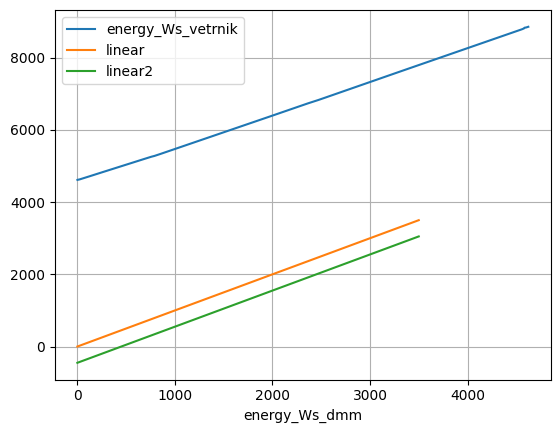

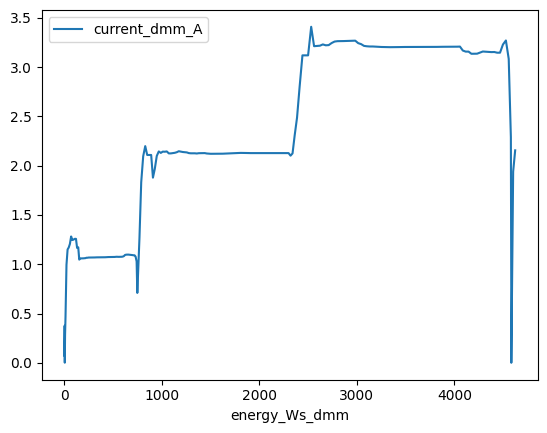

In [16]:
df.plot(x="energy_Ws_dmm", y="energy_Ws_vetrnik")
x = np.array([0, 3500])
plt.plot(x, x, label="linear")
plt.plot(x, x-450, label="linear2")
plt.grid("both")
plt.legend()
df.plot(x="energy_Ws_dmm", y="current_dmm_A")